## Analiza valorii epsilon pentru COUNT(Age > 50) cu OpenDP si Lomas

Acest notebook testeaza aplicarea mecanismului Laplace din OpenDP pentru interogarea COUNT(Age > 50) pe un dataset demonstrativ (Titanic) prin intermediul serverului Lomas.

Scopul este sa observam cum influenteaza parametrul epsilon precizia rezultatului si sa determinam un interval de valori epsilon care ofera un compromis acceptabil intre confidentialitate si utilitatea datelor.

/usr/local/lib/python3.12/site-packages/opendp_logger/deserialize.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Epsilon: 0.01, Rezultat: None
Epsilon: 0.05, Rezultat: None
Epsilon: 0.1, Rezultat: None
Epsilon: 0.2, Rezultat: None
Epsilon: 0.3, Rezultat: None
Epsilon: 0.5, Rezultat: None
Epsilon: 0.7, Rezultat: None
Epsilon: 1.0, Rezultat: None
Epsilon: 2.0, Rezultat: None
Epsilon: 3.0, Rezultat: None
Epsilon: 5.0, Rezultat: None
    epsilon valoare_dp  acceptabil
0      0.01       None       False
1      0.05       None       False
2      0.10       None       False
3      0.20       None       False
4      0.30       None       False
5      0.50       None       False
6      0.70       None       False
7      1.00       None       False
8      2.00       None       False
9      3.00       None       False
10     5.00       None       False


/usr/local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


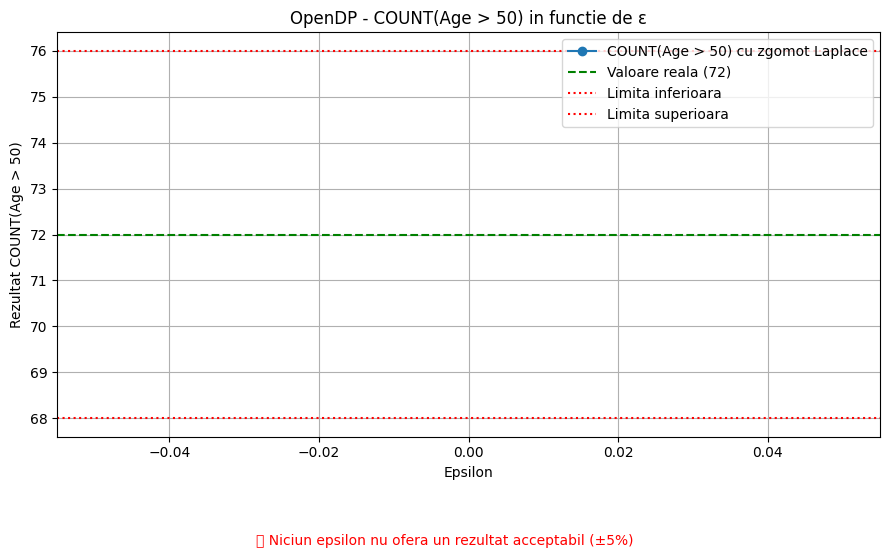

In [1]:
from lomas_client.client import Client
import json
import requests
import matplotlib.pyplot as plt
import pandas as pd

# Inițializare client Lomas
client = Client(
    url="http://lomas_server_dev",
    user_name="Jack",
    dataset_name="TITANIC"
)

# Funcție care trimite pipeline OpenDP pentru COUNT(Age > 50)
def pipeline_opendp_count_age_over_50(epsilon):
    pipeline_dict = {
        "version": "0.10.0",
        "ast": {
            "_type": "partial_chain",
            "lhs": {
                "_type": "partial_chain",
                "lhs": {
                    "_type": "partial_chain",
                    "lhs": {
                        "_type": "partial_chain",
                        "lhs": {
                            "_type": "partial_chain",
                            "lhs": {
                                "_type": "constructor",
                                "func": "make_chain_tt",
                                "module": "combinators",
                                "args": [
                                    {
                                        "_type": "constructor",
                                        "func": "make_select_column",
                                        "module": "transformations",
                                        "kwargs": {"key": "Age", "TOA": "String"}
                                    },
                                    {
                                        "_type": "constructor",
                                        "func": "make_split_dataframe",
                                        "module": "transformations",
                                        "kwargs": {
                                            "separator": ",",
                                            "col_names": {
                                                "_type": "list",
                                                "_items": [
                                                    "PassengerId", "Survived", "Pclass", "Name", "Sex",
                                                    "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"
                                                ]
                                            }
                                        }
                                    }
                                ]
                            },
                            "rhs": {
                                "_type": "constructor",
                                "func": "then_cast_default",
                                "module": "transformations",
                                "kwargs": {"TOA": "f64"}
                            }
                        },
                        "rhs": {
                            "_type": "constructor",
                            "func": "then_clamp",
                            "module": "transformations",
                            "kwargs": {"bounds": [0.0, 100.0]}
                        }
                    },
                    "rhs": {
                        "_type": "constructor",
                        "func": "then_filter",
                        "module": "transformations",
                        "kwargs": {"comparator": "gt", "value": 50.0}
                    }
                },
                "rhs": {
                    "_type": "constructor",
                    "func": "then_count",
                    "module": "transformations"
                }
            },
            "rhs": {
                "_type": "constructor",
                "func": "then_laplace",
                "module": "measurements",
                "kwargs": {"scale": 1.0 / epsilon}
            }
        }
    }

    opendp_json = json.dumps(pipeline_dict)
    body = {
        "dataset_name": "TITANIC",
        "opendp_json": opendp_json,
        "fixed_delta": 0.0
    }
    headers = {"user-name": "Jack"}
    r = requests.post("http://lomas_server_dev/opendp_query", json=body, headers=headers)
    return r.json()

# Parametri
valoare_reala = 72
interval = (valoare_reala - 4, valoare_reala + 4)  # ±5%
epsilons = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 2.0, 3.0, 5.0]

# Colectare rezultate
rezultate = []
for eps in epsilons:
    r = pipeline_opendp_count_age_over_50(eps)
    rezultat = r.get("result", {}).get("value", None)
    print(f"Epsilon: {eps}, Rezultat: {rezultat}")
    rezultate.append({
        "epsilon": eps,
        "valoare_dp": rezultat,
        "acceptabil": (
            rezultat is not None and interval[0] <= rezultat <= interval[1]
        )
    })

# Tabel rezultate
df = pd.DataFrame(rezultate)
print(df)

# Grafic
plt.figure(figsize=(9,5))
plt.plot(df["epsilon"], df["valoare_dp"], marker='o', label="COUNT(Age > 50) cu zgomot Laplace")
plt.axhline(y=valoare_reala, color='green', linestyle='--', label=f"Valoare reala ({valoare_reala})")
plt.axhline(y=interval[0], color='red', linestyle=':', label="Limita inferioara")
plt.axhline(y=interval[1], color='red', linestyle=':', label="Limita superioara")
plt.xlabel("Epsilon")
plt.ylabel("Rezultat COUNT(Age > 50)")
plt.title("OpenDP - COUNT(Age > 50) in functie de ε")
plt.grid(True)
plt.legend()

# Text sub grafic cu epsilon minim acceptabil
epsilon_ok = df[df["acceptabil"] == True]["epsilon"]
if not epsilon_ok.empty:
    min_eps = epsilon_ok.min()
    plt.gcf().text(0.5, -0.1, f"✅ Epsilon minim acceptabil (±5%): {min_eps}", ha='center', fontsize=10, color='black')
else:
    plt.gcf().text(0.5, -0.1, "❌ Niciun epsilon nu ofera un rezultat acceptabil (±5%)", ha='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()
